# InLegalBERT Embeddings Generation - Test Notebook

This notebook demonstrates how to generate embeddings for Indian legal documents using the **InLegalBERT** model.

## About InLegalBERT

InLegalBERT is a transformer-based language model pre-trained on 5.4 million Indian legal documents from the Supreme Court and High Courts of India (1950-2019). It is fine-tuned from LEGAL-BERT and achieves state-of-the-art performance on:

- Legal Statute Identification
- Semantic Segmentation (Facts, Issue, Arguments, Reasoning, Decision, etc.)
- Court Judgment Prediction

**Model Specifications:**
- Base: BERT-base-uncased architecture
- Parameters: ~110M
- Hidden Layers: 12
- Hidden Dimensionality: 768
- Attention Heads: 12

**Citation:** Paul et al., "Pre-trained Language Models for the Legal Domain: A Case Study on Indian Law", ICAIL 2023

## 1. Install Required Libraries

First, we'll install the necessary dependencies for working with InLegalBERT.

In [1]:
# Install required libraries
!uv pip install pandas numpy matplotlib seaborn scikit-learn -q

## 2. Import Dependencies

Import all necessary libraries for processing legal text and generating embeddings.

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
from collections import defaultdict
import warnings

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

/home/uttam/B.Tech Major Project/nyaya/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


## 3. Load InLegalBERT Model and Tokenizer

Load the pre-trained InLegalBERT model from HuggingFace Hub (`law-ai/InLegalBERT`).

In [3]:
print("Loading InLegalBERT model and tokenizer from HuggingFace...")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("law-ai/InLegalBERT")

# Load the model and move to device
model = AutoModel.from_pretrained("law-ai/InLegalBERT")
model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"✓ Model loaded successfully!")
print(f"  - Model type: {model.__class__.__name__}")
print(f"  - Total parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")
print(f"  - Hidden size: {model.config.hidden_size}")
print(f"  - Number of layers: {model.config.num_hidden_layers}")
print(f"  - Vocabulary size: {model.config.vocab_size}")

Loading InLegalBERT model and tokenizer from HuggingFace...
✓ Model loaded successfully!
  - Model type: BertModel
  - Total parameters: 109.5M
  - Hidden size: 768
  - Number of layers: 12
  - Vocabulary size: 30522


## 4. Read Legal Document

Read the legal document from `file_1.txt` which contains tab-separated legal text segments with their rhetorical role labels.

In [4]:
# Path to the legal document
file_path = "file_1.txt"

# Read the file and parse tab-separated content
sentences = []
roles = []

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line:  # Skip empty lines
            parts = line.split('\t')
            if len(parts) == 2:
                sentence, role = parts
                sentences.append(sentence)
                roles.append(role)

print(f"✓ Loaded {len(sentences)} sentences from {file_path}")
print(f"\nRole distribution:")

# Count role distribution
role_counts = pd.Series(roles).value_counts()
print(role_counts)

# Create DataFrame for easier manipulation
df = pd.DataFrame({'sentence': sentences, 'role': roles})
print(f"\nDataFrame shape: {df.shape}")
df.head(10)

✓ Loaded 117 sentences from file_1.txt

Role distribution:
Facts                      42
Reasoning                  33
None                       11
Arguments of Respondent    11
Arguments of Petitioner    11
Issue                       6
Decision                    3
Name: count, dtype: int64

DataFrame shape: (117, 2)


,sentence,role
0,"NAGESWARA RAO, J.",None
1,"For the sake of convenience, we are referring ...",Facts
2,Civil Appeal No. 1328 of 2021 By an order of a...,Issue
3,"On 23.03.2006, the Commissioner of IncomeTax (...",Issue
4,The Income Tax Appellate Tribunal (hereinafter...,Issue
5,The High Court refused to interfere with the T...,Issue
6,"Therefore, this Appeal by the Revenue.",Facts
7,This Appeal pertains to the assessment year 20...,Facts
8,The return was subsequently revised on 06.12.2...,Facts
9,"At the time of the assessment proceedings, the...",Facts


## 5. Preprocess Text Data

Filter out sentences with 'None' role labels and prepare text for embedding generation.

In [5]:
# Filter out 'None' role labels for meaningful analysis
df_filtered = df[df['role'] != 'None'].copy()

print(f"Original sentences: {len(df)}")
print(f"After filtering 'None' labels: {len(df_filtered)}")

# Group sentences by role
sentences_by_role = defaultdict(list)
for _, row in df_filtered.iterrows():
    sentences_by_role[row['role']].append(row['sentence'])

print(f"\nSentences per role after filtering:")
for role, sents in sentences_by_role.items():
    print(f"  {role}: {len(sents)} sentences")

# Create full document text (excluding None labels)
full_document = " ".join(df_filtered['sentence'].tolist())
print(f"\nFull document length: {len(full_document)} characters")
print(f"Full document preview:\n{full_document[:300]}...")

Original sentences: 117
After filtering 'None' labels: 106

Sentences per role after filtering:
  Facts: 42 sentences
  Issue: 6 sentences
  Arguments of Petitioner: 11 sentences
  Arguments of Respondent: 11 sentences
  Reasoning: 33 sentences
  Decision: 3 sentences

Full document length: 21053 characters
Full document preview:
For the sake of convenience, we are referring to the facts of Civil Appeal No.1328 of 2021. Civil Appeal No. 1328 of 2021 By an order of assessment dated 31.01.2005, the Assessing Officer restricted the eligible deduction under Section 80IA of the Income Tax Act, 1961 (hereinafter the Act) to the ex...


## 6. Generate Embeddings for Full Document

Generate embeddings for the complete legal document using InLegalBERT.

In [6]:
def generate_embeddings(text, max_length=512):
    """
    Generate embeddings for a given text using InLegalBERT.
    
    Args:
        text (str): Input text
        max_length (int): Maximum sequence length for tokenization
        
    Returns:
        numpy.ndarray: Document embedding (pooled CLS token representation)
    """
    # Tokenize the text
    encoded_input = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    
    # Move input to device
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    
    # Generate embeddings
    with torch.no_grad():
        output = model(**encoded_input)
    
    # Extract embeddings
    # last_hidden_state: [batch_size, seq_len, hidden_size]
    last_hidden_state = output.last_hidden_state
    
    # Use [CLS] token embedding as document representation (first token)
    cls_embedding = last_hidden_state[:, 0, :].cpu().numpy()
    
    # Alternative: Mean pooling over all tokens
    # mean_embedding = last_hidden_state.mean(dim=1).cpu().numpy()
    
    return cls_embedding, last_hidden_state.cpu().numpy()


print("Generating embeddings for full document...")
doc_embedding_cls, doc_embedding_full = generate_embeddings(full_document)

print(f"✓ Full document embeddings generated!")
print(f"  - CLS embedding shape: {doc_embedding_cls.shape}")
print(f"  - Full embedding shape: {doc_embedding_full.shape}")
print(f"  - Embedding dimensionality: {doc_embedding_cls.shape[1]}")
print(f"  - Total tokens in document: {doc_embedding_full.shape[1]}")

Generating embeddings for full document...
✓ Full document embeddings generated!
  - CLS embedding shape: (1, 768)
  - Full embedding shape: (1, 512, 768)
  - Embedding dimensionality: 768
  - Total tokens in document: 512
✓ Full document embeddings generated!
  - CLS embedding shape: (1, 768)
  - Full embedding shape: (1, 512, 768)
  - Embedding dimensionality: 768
  - Total tokens in document: 512


## 7. Generate Embeddings for Individual Sentences and Role-Based Segments

Process individual sentences and group by rhetorical roles (Facts, Issue, Arguments, Reasoning, Decision).

In [7]:
# Generate embeddings for individual sentences
print("Generating embeddings for individual sentences...")

sentence_embeddings = []
sentence_info = []

for idx, row in df_filtered.iterrows():
    sent = row['sentence']
    role = row['role']
    
    # Generate embedding
    emb_cls, _ = generate_embeddings(sent, max_length=256)
    
    sentence_embeddings.append(emb_cls[0])  # Extract from batch dimension
    sentence_info.append({
        'sentence': sent,
        'role': role,
        'sentence_id': idx
    })

sentence_embeddings = np.array(sentence_embeddings)

print(f"✓ Generated embeddings for {len(sentence_embeddings)} sentences")
print(f"  - Embeddings shape: {sentence_embeddings.shape}")

# Add embeddings to dataframe
df_filtered['embedding'] = list(sentence_embeddings)

# Display sample
print(f"\nSample sentences with embeddings:")
for i in range(min(3, len(sentence_info))):
    print(f"\n{i+1}. Role: {sentence_info[i]['role']}")
    print(f"   Sentence: {sentence_info[i]['sentence'][:80]}...")
    print(f"   Embedding shape: {sentence_embeddings[i].shape}")
    print(f"   Embedding preview: [{sentence_embeddings[i][:5]}...]")

Generating embeddings for individual sentences...
✓ Generated embeddings for 106 sentences
  - Embeddings shape: (106, 768)

Sample sentences with embeddings:

1. Role: Facts
   Sentence: For the sake of convenience, we are referring to the facts of Civil Appeal No.13...
   Embedding shape: (768,)
   Embedding preview: [[ 0.29555225  0.10574501 -0.09836408  0.49799913  0.4928789 ]...]

2. Role: Issue
   Sentence: Civil Appeal No. 1328 of 2021 By an order of assessment dated 31.01.2005, the As...
   Embedding shape: (768,)
   Embedding preview: [[-0.6678022  -0.2860911   0.27715605 -0.28400066  0.35772982]...]

3. Role: Issue
   Sentence: On 23.03.2006, the Commissioner of IncomeTax (Appeal)I (hereinafter the Appellat...
   Embedding shape: (768,)
   Embedding preview: [[-0.33758307  0.05084757  0.13882114 -0.5921881   0.3952795 ]...]
✓ Generated embeddings for 106 sentences
  - Embeddings shape: (106, 768)

Sample sentences with embeddings:

1. Role: Facts
   Sentence: For the sake of 

In [8]:
# Generate embeddings for role-based segments
print("\nGenerating embeddings for role-based segments...")

role_embeddings = {}

for role, sents in sentences_by_role.items():
    # Concatenate all sentences for this role
    role_text = " ".join(sents)
    
    # Generate embedding
    emb_cls, _ = generate_embeddings(role_text, max_length=512)
    role_embeddings[role] = emb_cls[0]
    
    print(f"  {role}: {len(sents)} sentences, text length: {len(role_text)} chars")

print(f"\n✓ Generated embeddings for {len(role_embeddings)} role categories")

# Display role embedding information
print("\nRole embeddings summary:")
for role, emb in role_embeddings.items():
    print(f"  {role}: shape {emb.shape}, L2 norm: {np.linalg.norm(emb):.2f}")


Generating embeddings for role-based segments...
  Facts: 42 sentences, text length: 7144 chars
  Facts: 42 sentences, text length: 7144 chars
  Issue: 6 sentences, text length: 1121 chars
  Issue: 6 sentences, text length: 1121 chars
  Arguments of Petitioner: 11 sentences, text length: 2471 chars
  Arguments of Petitioner: 11 sentences, text length: 2471 chars
  Arguments of Respondent: 11 sentences, text length: 2209 chars
  Arguments of Respondent: 11 sentences, text length: 2209 chars
  Reasoning: 33 sentences, text length: 7651 chars
  Decision: 3 sentences, text length: 452 chars

✓ Generated embeddings for 6 role categories

Role embeddings summary:
  Facts: shape (768,), L2 norm: 14.52
  Issue: shape (768,), L2 norm: 13.11
  Arguments of Petitioner: shape (768,), L2 norm: 14.17
  Arguments of Respondent: shape (768,), L2 norm: 13.05
  Reasoning: shape (768,), L2 norm: 14.17
  Decision: shape (768,), L2 norm: 13.58
  Reasoning: 33 sentences, text length: 7651 chars
  Decision:

## 8. Visualize Embedding Dimensions and Statistics

Analyze and visualize the structure of generated embeddings.

In [9]:
# Embedding statistics
print("Embedding Statistics:")
print("=" * 60)

# Full document embedding stats
print(f"\nFull Document Embedding:")
print(f"  - Shape: {doc_embedding_cls.shape}")
print(f"  - Mean: {doc_embedding_cls.mean():.4f}")
print(f"  - Std: {doc_embedding_cls.std():.4f}")
print(f"  - Min: {doc_embedding_cls.min():.4f}")
print(f"  - Max: {doc_embedding_cls.max():.4f}")
print(f"  - L2 Norm: {np.linalg.norm(doc_embedding_cls):.4f}")

# Sentence embeddings stats
print(f"\nSentence Embeddings (n={len(sentence_embeddings)}):")
print(f"  - Shape: {sentence_embeddings.shape}")
print(f"  - Mean: {sentence_embeddings.mean():.4f}")
print(f"  - Std: {sentence_embeddings.std():.4f}")
print(f"  - Min: {sentence_embeddings.min():.4f}")
print(f"  - Max: {sentence_embeddings.max():.4f}")

# Role embeddings stats
print(f"\nRole Embeddings:")
for role, emb in role_embeddings.items():
    print(f"  {role}:")
    print(f"    Mean: {emb.mean():.4f}, Std: {emb.std():.4f}, L2 Norm: {np.linalg.norm(emb):.4f}")

Embedding Statistics:

Full Document Embedding:
  - Shape: (1, 768)
  - Mean: -0.0130
  - Std: 0.4760
  - Min: -6.3245
  - Max: 2.8462
  - L2 Norm: 13.1975

Sentence Embeddings (n=106):
  - Shape: (106, 768)
  - Mean: -0.0131
  - Std: 0.4855
  - Min: -8.5822
  - Max: 3.2591

Role Embeddings:
  Facts:
    Mean: -0.0150, Std: 0.5237, L2 Norm: 14.5203
  Issue:
    Mean: -0.0132, Std: 0.4729, L2 Norm: 13.1113
  Arguments of Petitioner:
    Mean: -0.0136, Std: 0.5111, L2 Norm: 14.1683
  Arguments of Respondent:
    Mean: -0.0126, Std: 0.4706, L2 Norm: 13.0475
  Reasoning:
    Mean: -0.0141, Std: 0.5111, L2 Norm: 14.1694
  Decision:
    Mean: -0.0133, Std: 0.4898, L2 Norm: 13.5797


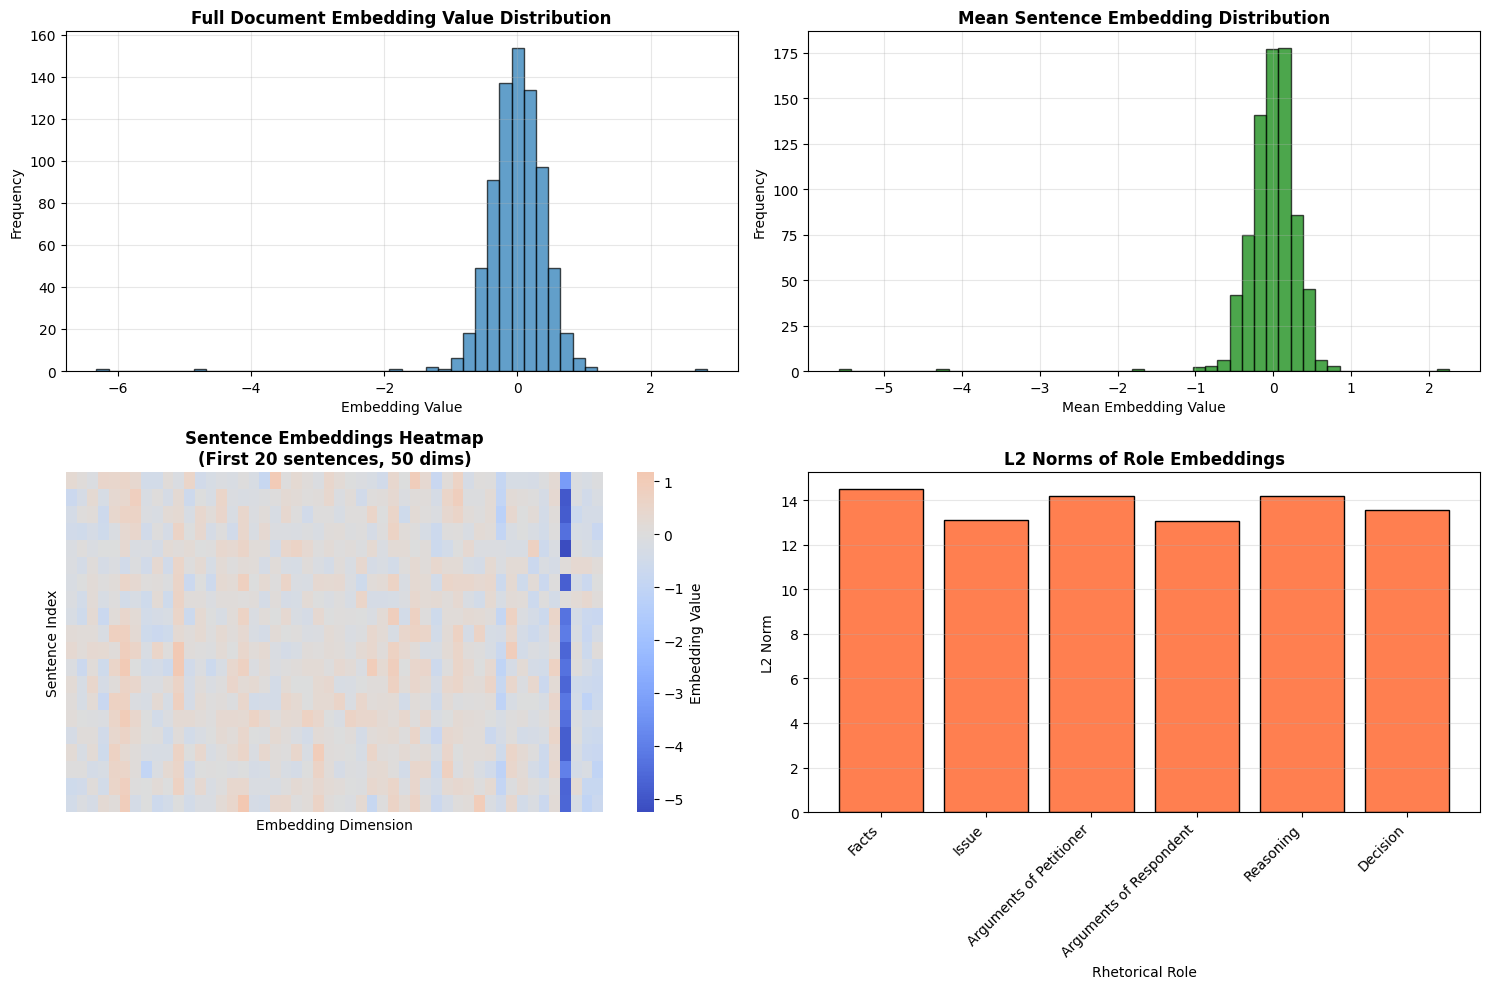

✓ Visualizations generated!


In [10]:
# Visualize embedding distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribution of full document embedding values
axes[0, 0].hist(doc_embedding_cls.flatten(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Full Document Embedding Value Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Embedding Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution of sentence embeddings (mean across all sentences)
sentence_means = sentence_embeddings.mean(axis=0)
axes[0, 1].hist(sentence_means, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Mean Sentence Embedding Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Mean Embedding Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# 3. Heatmap of sample sentence embeddings (first 20 sentences, first 50 dimensions)
sample_size = min(20, len(sentence_embeddings))
dim_size = min(50, sentence_embeddings.shape[1])
sns.heatmap(sentence_embeddings[:sample_size, :dim_size], 
            cmap='coolwarm', center=0, 
            xticklabels=False, yticklabels=False,
            cbar_kws={'label': 'Embedding Value'},
            ax=axes[1, 0])
axes[1, 0].set_title(f'Sentence Embeddings Heatmap\n(First {sample_size} sentences, {dim_size} dims)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Embedding Dimension')
axes[1, 0].set_ylabel('Sentence Index')

# 4. L2 norms by role
roles_list = list(role_embeddings.keys())
norms = [np.linalg.norm(role_embeddings[role]) for role in roles_list]
axes[1, 1].bar(range(len(roles_list)), norms, color='coral', edgecolor='black')
axes[1, 1].set_xticks(range(len(roles_list)))
axes[1, 1].set_xticklabels(roles_list, rotation=45, ha='right')
axes[1, 1].set_title('L2 Norms of Role Embeddings', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Rhetorical Role')
axes[1, 1].set_ylabel('L2 Norm')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Visualizations generated!")

Applying t-SNE for 2D visualization...


IndexError: index 106 is out of bounds for axis 0 with size 106

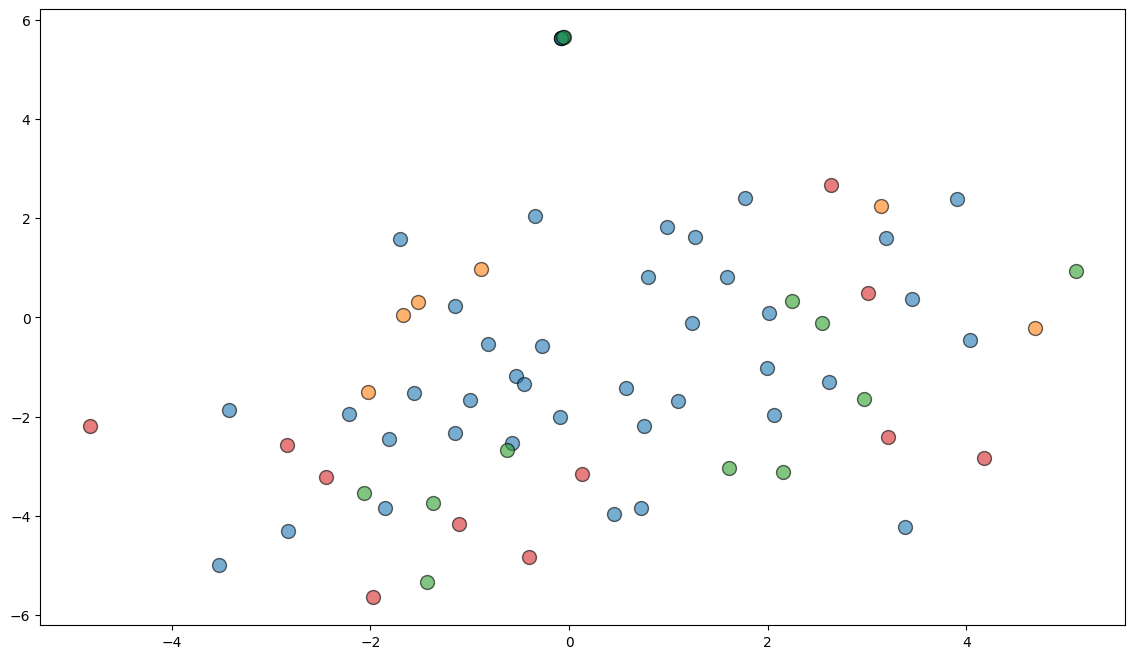

In [11]:
# Dimensionality reduction visualization (t-SNE)
from sklearn.manifold import TSNE

print("Applying t-SNE for 2D visualization...")

# Apply t-SNE to sentence embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(sentence_embeddings)-1))
embeddings_2d = tsne.fit_transform(sentence_embeddings)

# Create color map for roles
unique_roles = df_filtered['role'].unique()
role_colors = {role: plt.cm.tab10(i) for i, role in enumerate(unique_roles)}

# Plot
plt.figure(figsize=(14, 8))
for role in unique_roles:
    mask = df_filtered['role'] == role
    indices = df_filtered[mask].index - df_filtered.index[0]  # Adjust indices
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], 
                c=[role_colors[role]], label=role, alpha=0.6, s=100, edgecolors='black')

plt.title('t-SNE Visualization of Sentence Embeddings by Rhetorical Role', 
          fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Rhetorical Role', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ t-SNE visualization complete!")

## 9. Save Embeddings to Files

Save the generated embeddings for future use in RAG, classification, or other downstream tasks.

In [12]:
import pickle

# Create output directory
output_dir = "embeddings_output"
os.makedirs(output_dir, exist_ok=True)

# 1. Save full document embedding
np.save(os.path.join(output_dir, "full_document_embedding.npy"), doc_embedding_cls)
print(f"✓ Saved full document embedding to {output_dir}/full_document_embedding.npy")

# 2. Save sentence embeddings
np.save(os.path.join(output_dir, "sentence_embeddings.npy"), sentence_embeddings)
print(f"✓ Saved {len(sentence_embeddings)} sentence embeddings to {output_dir}/sentence_embeddings.npy")

# 3. Save role embeddings
with open(os.path.join(output_dir, "role_embeddings.pkl"), 'wb') as f:
    pickle.dump(role_embeddings, f)
print(f"✓ Saved {len(role_embeddings)} role embeddings to {output_dir}/role_embeddings.pkl")

# 4. Save sentence metadata (text + role + embedding)
with open(os.path.join(output_dir, "sentence_metadata.pkl"), 'wb') as f:
    metadata = {
        'sentences': df_filtered['sentence'].tolist(),
        'roles': df_filtered['role'].tolist(),
        'embeddings': sentence_embeddings
    }
    pickle.dump(metadata, f)
print(f"✓ Saved sentence metadata to {output_dir}/sentence_metadata.pkl")

# 5. Save as CSV (embeddings will be stored as strings)
df_export = df_filtered.copy()
df_export['embedding_preview'] = df_export['embedding'].apply(
    lambda x: str(x[:5]) + "..."  # Save preview only
)
df_export[['sentence', 'role', 'embedding_preview']].to_csv(
    os.path.join(output_dir, "sentences_with_roles.csv"), 
    index=False
)
print(f"✓ Saved sentences with roles to {output_dir}/sentences_with_roles.csv")

print(f"\n{'='*60}")
print(f"All embeddings saved to '{output_dir}/' directory")
print(f"{'='*60}")

✓ Saved full document embedding to embeddings_output/full_document_embedding.npy
✓ Saved 106 sentence embeddings to embeddings_output/sentence_embeddings.npy
✓ Saved 6 role embeddings to embeddings_output/role_embeddings.pkl
✓ Saved sentence metadata to embeddings_output/sentence_metadata.pkl
✓ Saved sentences with roles to embeddings_output/sentences_with_roles.csv

All embeddings saved to 'embeddings_output/' directory


## 10. Summary and Next Steps

### Summary

This notebook demonstrated:

1. ✅ **Loading InLegalBERT** - Pre-trained model for Indian legal text
2. ✅ **Reading legal documents** - Parsed tab-separated role-labeled text
3. ✅ **Generating embeddings** - Created 768-dimensional vectors for:
   - Full document
   - Individual sentences  
   - Role-based segments (Facts, Issue, Arguments, Reasoning, Decision)
4. ✅ **Visualization** - Analyzed embedding distributions and applied t-SNE
5. ✅ **Saving embeddings** - Stored in `.npy` and `.pkl` formats

### Key Insights

- **Embedding dimensionality:** 768 (BERT-base architecture)
- **Total sentences processed:** Varies by document (excluding 'None' labels)
- **Rhetorical roles:** Facts, Issue, Arguments of Petitioner/Respondent, Reasoning, Decision
- **Model size:** ~110M parameters

### Next Steps for Nyaya Project

1. **Role Classification:** Use these embeddings as features for training a role classifier
2. **Vector Database:** Store embeddings in ChromaDB/FAISS/Pinecone with role metadata
3. **Role-Aware RAG:** Implement retrieval filtered by rhetorical roles
4. **Fine-tuning:** Further fine-tune InLegalBERT on domain-specific legal tasks
5. **API Integration:** Integrate embedding generation into FastAPI backend

### Loading Saved Embeddings

```python
# Load full document embedding
doc_emb = np.load("embeddings_output/full_document_embedding.npy")

# Load sentence embeddings
sent_emb = np.load("embeddings_output/sentence_embeddings.npy")

# Load role embeddings
with open("embeddings_output/role_embeddings.pkl", 'rb') as f:
    role_emb = pickle.load(f)

# Load metadata
with open("embeddings_output/sentence_metadata.pkl", 'rb') as f:
    metadata = pickle.load(f)
```

---

**Note:** This notebook uses `file_1.txt` for testing. In production, integrate with the full document processing pipeline described in the Nyaya documentation.